In [ ]:
# Using huggingface Transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoConfig
from sklearn.model_selection import train_test_split
import numpy as np
import transformers
from torch.utils.data import Dataset, DataLoader


In [ ]:
from transformers import get_scheduler

# Data loading, preprocessing - Same as baseline model

In [ ]:
train = pd.read_csv("drive/MyDrive/Deep Learning/Project/train.csv")
test = pd.read_csv("drive/MyDrive/Deep Learning/Project/test.csv")

In [ ]:
train['full_text'] = train['full_text'].str.lower()
test['full_text'] = test['full_text'].str.lower()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

In [ ]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,i think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,when a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"dear, principal\n\nif u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,the best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [ ]:
test.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,do you think students would benefit from being...
2,00367BB2546B,"thomas jefferson once states that ""it is wonde..."


In [ ]:
scores = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [ ]:
train['full_text'].iloc[20]

"interducaions\n\n:summer vacation should be longer more family time we can do swimming and camping summer brian relaxation, studies cause stress but if we stop after every two months it will divide our follows, are can go on family trips. summer warmest seasons of the year occurring between springs, and autumn. a period considered as a time of fulfillment, happiness, or beauty.\n\nthe summer is good seasons for vacation some people fixed holiday where to go for adventure, and traveling. summer is fan,feeling freedom, and enjoble season.\n\nparagraph# 1\n\nstudents should take longer break if don't take break the brian is can't consecrate and focus and studies might be tried because\n\nstudents going to school entered of the year human brian is not like machine working as all the time the have to longer break. summer is good opportunity for every one specially to students can go traveling spent time with our family , friends and go to picnic. family is good opportunity to spent time wi

In [ ]:
train[scores].iloc[20]

cohesion       2.5
syntax         2.5
vocabulary     3.0
phraseology    2.0
grammar        2.0
conventions    2.5
Name: 20, dtype: float64

In [ ]:
train['full_text']=train['full_text'].str.replace(r'\n', ' ')

<ipython-input-12-eb10e67f09a2>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['full_text']=train['full_text'].str.replace(r'\n', ' ')


In [ ]:
num_tokens = train['full_text'].apply(lambda x: x.split()).apply(len)

In [ ]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,i think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,when a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"dear, principal if u change the school policy...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,the best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [ ]:
train['total_scores'] = train[scores].sum(axis = 1)

In [ ]:
train['total_scores'].describe()

count    3911.000000
mean       18.621836
std         3.365642
min         6.000000
25%        16.000000
50%        18.500000
75%        21.000000
max        30.000000
Name: total_scores, dtype: float64

In [ ]:
# Need to have this for Deberta tokenizer
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Again, taken from huggingface transformers library
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.8/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Again, pretty much the same as the baseline model load.
class train_custom_set(Dataset):
  def __init__(self, data):
    self.max_seq_len = 512
    self.sent_toks_data = data
  def __getitem__(self,idx):

    sent_tok = self.sent_toks_data['full_text'][idx]
    berttokssent = tokenizer.encode_plus(sent_tok, None,  max_length = self.max_seq_len, truncation = True, add_special_tokens = True, padding = 'max_length')
    # Can alternatively use return_tensors = 'pt' source:  https://huggingface.co/docs/transformers/v4.25.1/en/main_classes/tokenizer#transformers.PreTrainedTokenizer
    tensor_custom = {"input_ids": torch.tensor(berttokssent['input_ids'], dtype=torch.long), "token_type_ids": torch.tensor(berttokssent['token_type_ids'], dtype=torch.long), "attention_mask": torch.tensor(berttokssent['attention_mask'], dtype=torch.long)}
    #berttokssent['input_ids'] = berttokssent['input_ids'].squeeze(0)
    label = torch.tensor(self.sent_toks_data.loc[idx, scores].to_list())

    return tensor_custom, label
  
  def __len__(self):
    return len(self.sent_toks_data)
  
  



In [ ]:
class TestDataset(Dataset):
  def __init__(self, data):
    self.max_seq_len = 512
    self.sent_toks_data = data
  def __getitem__(self,idx):
    sent_tok = self.sent_toks_data['full_text'][idx]
    berttokssent = tokenizer.__call__(sent_tok, None, max_length = self.max_seq_len, truncation = True, add_special_tokens = True, padding = 'max_length', return_tensors = 'pt')    
    tensor_custom = {"input_ids": torch.tensor(berttokssent['input_ids'], dtype=torch.long), "token_type_ids": torch.tensor(berttokssent['token_type_ids'], dtype=torch.long), "attention_mask": torch.tensor(berttokssent['attention_mask'], dtype=torch.long)}
    return tensor_custom
  def __len__(self):
    return len(self.sent_toks_data)
  

In [ ]:
tr, va = train_test_split(train, test_size = 0.2, shuffle = True)

In [ ]:
tr = tr.reset_index(drop = True)
va = va.reset_index()
test = test.reset_index()

In [ ]:
train_dataset = train_custom_set(tr)
validation_dataset = train_custom_set(va)
test_dataset = TestDataset(test)

In [ ]:
def mcrmse_loss(op, tgt):

  return torch.mean(torch.sqrt(torch.mean(torch.square(op - tgt), dim = 0)))

### Here's where things change. We use a DeBERTa model instead. This model output is pooled by using a max pooling layer and the first 5 layers are frozen on the encoder side. We also added a dropout layer to improve the chances of it not overfitting the data. 

In [ ]:
class M_pool(nn.Module):
  '''
  Adapted from the work of Debarshi Chanda
  https://www.kaggle.com/code/debarshichanda/fb3-custom-hf-trainer-w-b-starter?scriptVersionId=104880636&cellId=24
  '''
  def __init__(self):
    super(M_pool, self).__init__()
  def forward(self, last_h_value, Attn_mask):
    im_expansion = Attn_mask.unsqueeze(-1).expand(last_h_value.size()).float()
    aggregated_embed = torch.sum(last_h_value * im_expansion, 1)
    sum_mask = im_expansion.sum(1)
    sum_mask = torch.clamp(sum_mask, min=1e-9)
    m_embeddings = aggregated_embed / sum_mask
    return m_embeddings

In [ ]:
class Final_Model(nn.Module):
  
  def __init__(self):
    super(Final_Model, self).__init__()
    self.pool_layer = M_pool()
    self.bertencoder = AutoModel.from_pretrained("microsoft/deberta-v3-base")
    self.dropout = nn.Dropout(0.5) 
    self.fc = nn.Linear(self.bertencoder.config.hidden_size, 6)
    # Disable gradient computation to freeze the layers.
    # In this case we have frozen 5 layers.
    for nu, par in enumerate(self.bertencoder.base_model.parameters()):
      if nu <= 5:
        par.requires_grad = False
  
  def forward(self, x):

    output = self.bertencoder(**x, return_dict = True)
    output = self.pool_layer(output['last_hidden_state'], x['attention_mask'])
    output = self.dropout(output)
    output = self.fc(output)

    return output


In [ ]:
model = Final_Model().to(device)

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Hyperparameters.
learning_rate = 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
batch_size = 8
epochs = 10

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validation_dataloader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = True)

In [ ]:
step_tran = epochs * len(train_dataloader)
# learning rate scheduler adapted from official huggingface examples on pytorch.
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=step_tran
)

## Traning new model

In [ ]:
from tqdm.auto import tqdm
def train_model(model):
  loss_history = {'train_loss':[],'val_loss':[]}
  
  for epoch in range(epochs):
    progress_bar = tqdm(range(step_tran//10))
    print(f'Epoch {epoch+1}/{epochs}')
    model.train()
    train_loss = []
    valid_loss = []
    for samples, labels in train_dataloader:
      #samples = samples.to(device)
      samples = {x:samples[x].to(device) for x in samples.keys()}
      labels = labels.to(device)
      #print(samples)
      #samples['input_ids'] = samples['input_ids']
      #print(samples['input_ids'].shape)
      output = model(samples)
      loss = mcrmse_loss(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      lr_scheduler.step()
      train_loss.append(loss.detach().cpu().numpy())
      progress_bar.update(1)
    
    model.eval()

    with torch.no_grad():
      for samples, labels in validation_dataloader:
        
        #samples = samples.to(device)
        samples = {x:samples[x].to(device) for x in samples.keys()}
        labels = labels.to(device)
        output = model(samples)
        loss = mcrmse_loss(output, labels)
        valid_loss.append(loss.detach().cpu().numpy())


    loss_history['train_loss'].append(np.mean(train_loss))
    loss_history['val_loss'].append(np.mean(valid_loss))
    
  
    print('\ntrain loss {:.3f} \t val loss {:.3f}'.format(np.mean(train_loss), np.mean(valid_loss)))
  
  return loss_history

In [ ]:
model_losses = train_model(model)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10

train loss 0.696 	 val loss 0.487


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10

train loss 0.577 	 val loss 0.473


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10

train loss 0.532 	 val loss 0.512


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10

train loss 0.497 	 val loss 0.464


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10

train loss 0.467 	 val loss 0.464


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10

train loss 0.440 	 val loss 0.505


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10

train loss 0.419 	 val loss 0.468


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10

train loss 0.410 	 val loss 0.517


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10

train loss 0.390 	 val loss 0.495


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10

train loss 0.381 	 val loss 0.505


# Plotting final results

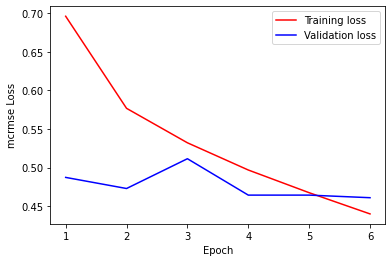

In [ ]:
plt.plot(model_losses['train_loss'][:6], color = 'red')
plt.plot(model_losses['val_loss'][:6], color = 'blue')
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('Epoch')
plt.ylabel('mcrmse Loss')
plt.xticks([0,1,2,3,4,5], range(1,7))
plt.show()

In [ ]:
torch.cuda.empty_cache()